# Welcome to the SAGAN fit tutorial

We are lucky, WFIRST give us a preview event of its work. 
Let's have a look to your choice lightcurve first.

In [1]:
## First import the required libraries
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import time

lib_path = os.path.abspath(os.path.join('../'))
sys.path.append(lib_path)

from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA import microlmodels

First, let 's have a look to this event!

<IPython.core.display.Javascript object>


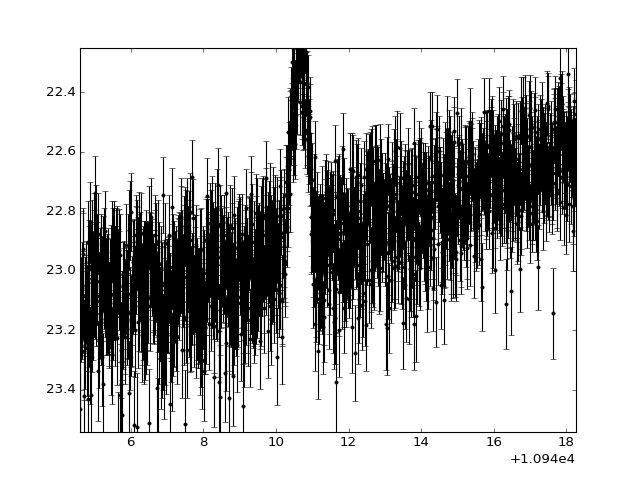

In [3]:
### Read only 1/16 points for speed-up. 
WFIRST_data = np.loadtxt('./WFIRST_binary_SAGAN.dat')[::1]

### Lets have a look on what it is exactly :
plt.errorbar(WFIRST_data[:,0]-2450000,WFIRST_data[:,1],yerr = WFIRST_data[:,2],fmt='.k')
plt.gca().invert_yaxis()
plt.show()


Well, it looks similar to a point-source point lens model except around 7815 HJD. Let's try a PSPL fit then.
To do so, we need to define an event, then define a telescope and add it to the event class.


In [4]:
### Create an event object. You can choose the name and RA,DEC in degrees :

your_event = event.Event()
your_event.name = 'WFIRST binary'
your_event.ra = 269.39166666666665 
your_event.dec = -29.22083333333333

###### Let's define the WFIRST observations

wfirst = telescopes.Telescope(name='WFIRST', camera_filter='I', light_curve_magnitude=WFIRST_data)

your_event.telescopes.append(wfirst)


OK now we can fit this event with a PSPL model. And fit it with a Levenberg-Marquardt algorithm, given the good data quality.


Start fit on WFIRST binary, with model PSPL and method LM
check_event  : Everything looks fine, this event can be fitted
initial_guess  : Initial parameters guess SUCCESS
lmarquardt  : Levenberg_marquardt fit SUCCESS
[2460963.0628666827, 0.46814016966123945, 22.03713844569258, 40.88105489873847, -0.11685481560012341, 22796.132593481852]


<IPython.core.display.Javascript object>


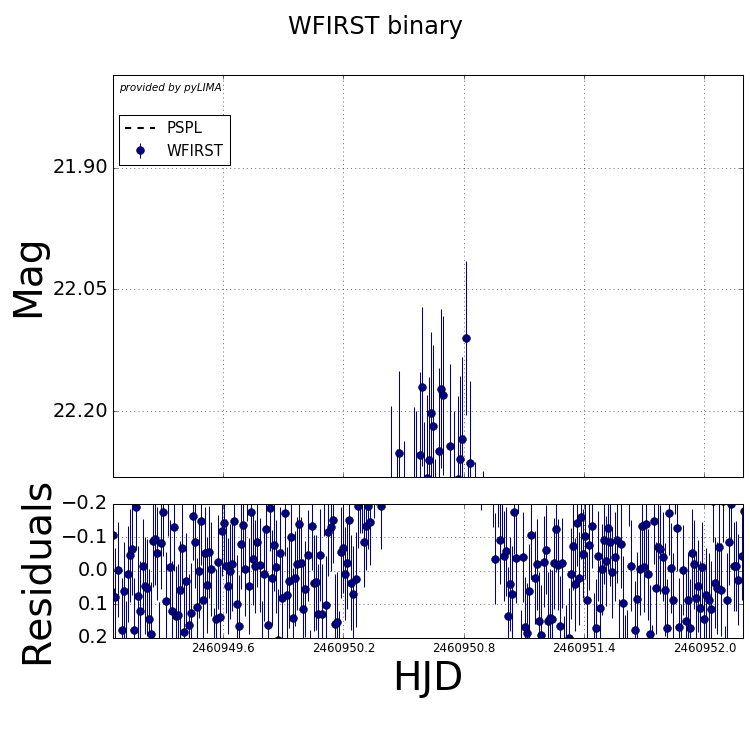

<IPython.core.display.Javascript object>


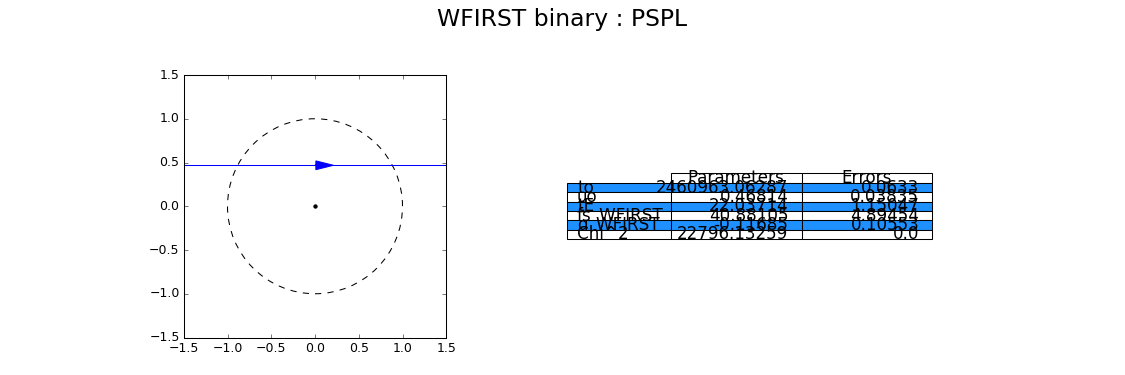

Chi2_LM : 22796.1325935


In [5]:
### Construct the model.
pspl_model = microlmodels.create_model('PSPL', your_event)

### Fit your_event with model_1.
your_event.fit(pspl_model,'LM')
your_event.fits[0].produce_outputs()
print 'Chi2_LM :',your_event.fits[0].outputs.fit_parameters.chichi
plt.show()



Hey, not to bad! Given the short duration of the anomaly and the good PSPL fit, this probably mean our anomaly is due to a planet. Then we can make some deduction. To do so, we have to define :

- delta_t = the duration of the anomaly
- delta_A = the amplitude of the anomaly 
- U(t_anomaly) = the impact parameter at the time  of anomaly

You can easily derive these properties by zooming around the anomaly!

In [10]:
### First derive delta_t in days.
delta_t = 1

### Then derive delta_I, the amplitude of the anomaly in magnitude unit
delta_I = 23.0-22.1

delta_A = 10**((delta_I)/2.5)

### Then the impact parameter at the anomaly time U(t_anomaly)
t_anomaly = 2460951

### Finally, extract PSPL parameters from first fit 
to = your_event.fits[0].outputs.fit_parameters.to
uo = your_event.fits[0].outputs.fit_parameters.uo
tE = your_event.fits[0].outputs.fit_parameters.tE

U_peak  = (uo**2+(t_anomaly-to)**2/tE**2)**0.5

print delta_A

2.29086765277


All right! We can then derive some binary parameters using this :

- s = (U_peak+(U_peak^2+4)^0.5)/2  This is accurate
- rho = delta_t/(2*tE)  This is NOT accurate
- q = delta_A*rho^2  This is NOT accurate
- alpha = arcsin(uo/U_peak) This is accurate

In [12]:
### Let's have s, rho, q and alpha
s = (U_peak+(U_peak**2+4)**0.5)/2
rho = delta_t/(2*tE)*(2/delta_A)**0.5
q = delta_A/2*rho**2
alpha = -np.arcsin(uo/U_peak) # the sign - comes from pyLIMA angle convention

print 'rho:',rho
print 's:',s
print 'q:',q
print 'alpha:',alpha
print U_peak

rho: 0.0211997042412
s: 1.42300717596
q: 0.000514789415093
alpha: -0.707519854555
0.720270031069


OK, enough work for you. We have enough guess to fit the event. To be sure, we gonna use a general solver using differential evolution. But thanks to our guess, we can reduce a lot the parameter space!

In [ ]:
### Let's define a binary model
binary_model = microlmodels.create_model('USBL', your_event, model_arguments = [])

### Speed up computations
binary_model.USBL_windows = [2457780,2457850]

### to boundaries
binary_model.parameters_boundaries[0] = [2457799,2457801]
### uo boundaries
binary_model.parameters_boundaries[1] = [0.5,0.6]
### tE boundaries
binary_model.parameters_boundaries[2] = [60,65]
### rho boundaries
binary_model.parameters_boundaries[3] = [0.001,0.05]
### log_10(s) boundaries
binary_model.parameters_boundaries[4] = [0.1,0.2]
### log_10(q) boundaries
binary_model.parameters_boundaries[5] = [-5.0,-3.0]
### alpha boundaries
binary_model.parameters_boundaries[6] = [-2.0,-1.0]
#binary_model.parameters_guess = [2457799.95,0.54,61.5,0.0077,0.128,-4.17,-1.15]
### DE_population_size scale the size of the DE population. More it is, bigger is your chance to find the minima
### but slower it is. 5 should give you a result in ~ 5 to 20 minutes.
start = time.time()
your_event.fit(binary_model, 'DE',DE_population_size = 15)
print time.time()-start

import pdb; pdb.set_trace()
your_event.fits[-1].produce_outputs()
plt.show()

Congrats for you binary fit!


In [ ]:
print your_event.fits[-1].model.parameters_boundaries


In [ ]:
print np.median(your_event.fits[-1].MCMC_chains[:,:,3])


In [ ]:
print your_event.fits[-1].MCMC_probabilities
    

In [ ]:
print np.max( your_event.fits[-1].MCMC_probabilities)

In [ ]:
print your_event.fits[-1].MCMC_chains[:,:,4]

In [ ]:
print np.median(your_event.fits[-1].MCMC_chains[:,:,4])
